<a href="https://colab.research.google.com/github/Wilkingc/ddc-datascience/blob/main/Project_5_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wilking Chali Alphonse 18/11/2024

## Problem definition

This project consist in three parts:

First)
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is provide the capability to
- Take one person from the list as input and output the 10 other people who's overview are "closest" to the person in a Natural Language Processing sense
- Also output the sentiment of the overview of the person.

2 Second)
- For the same person from step 1), use the Wikipedia API to access the whole content of that person's Wikipedia page.
- The goal of part 2) is to produce the capability to:
  1. For that Wikipedia page determine the sentiment of the entire page
  1. Print out the Wikipedia article
  1. Collect the Wikipedia pages from the 10 nearest neighbors in Step 1)
  1. Determine the nearness ranking of these 10 to your main subject based on their entire Wikipedia page
  1. Compare the nearest ranking from Step 1) with the Wikipedia page nearness ranking

3 Third)
  - Create an interactive notebook where we can select a person from the dataset and output the 10 closest person in a Natural Language Processing sense.

## Imports

In [ ]:
import numpy as np
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import NearestNeighbors
import random
import re
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import nltk
nltk.download('omw-1.4')
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
! python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## File path & read data

In [ ]:
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv'
data1 = pd.read_csv(url)
data1.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Part 1

### Data Cleaning

In [ ]:
data_copy = data1.copy() #Let's make a copy of the dataset
df = data_copy

In [ ]:
def process_data (text):
  '''
  This function will take a value and apply the lower case method, remove white spaces and characters and convert the text to TextBlob
  '''
  text = text.lower()
  text = re.sub(r"[^\w\s]", "", text)
  text = TextBlob(text)

  return text

In [ ]:
df['text'] = df['text'].apply(process_data) # Apply the function to our dataset

In [ ]:
df['text'].loc[1]  # Display some data to make sure the function cleaned the data

TextBlob("alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychiatry pharmacology and ophthalmology he is a full professor and vicechair of the department of psychiatry at ohsu oregon health science university and holds an md and phd prior to moving to oregon in 1981 lewy was at the national institute of mental health nimh in bethesda maryland working with senior colleague thomas wehr in oregon he has worked closely with robert l sack as of december 2005 he had 94 publications available on pubmed he describes his research as follows my laboratory studies chronobiologic sleep and mood disorders these disorders include winter depression jet lag maladaptation to shift work and certain types of sleep disturbances relying on a very precise assay for plasma melatonin a hormone that has a clearly defined 24hour pattern of secretion biological rhythm disorders can be assessed and their treatment can be monitored current research is focused on developing

In [ ]:
def singularize_text(text):
  '''
  This function lemmatize by splitting the data and returns a join version of it to mantain integrity
  '''

  lemmatizer = WordNetLemmatizer()
  words = text.split()  # Split the text into words
  singularized_words = [lemmatizer.lemmatize(word) for word in words]

  return ' '.join(singularized_words)

In [ ]:
df['text'] = df['text'].apply(singularize_text)

### Bag of words

In [ ]:
vectorizer = CountVectorizer(stop_words='english') # Transfor the text into a bag of words
bow = vectorizer.fit_transform(df["text"])
#bow = bow.toarray() # Tranform the result to a numpy array

### TF-IDF

In [ ]:
# Perform the TF-IDF transformation - (CountVectorizer + TfidfTransformer)
tf_idf_tran = TfidfTransformer()
tf_idf = tf_idf_tran.fit_transform(bow)
#tf_idf = tf_idf.toarray()
tf_idf

<42786x423646 sparse matrix of type '<class 'numpy.float64'>'
	with 5761185 stored elements in Compressed Sparse Row format>

### K- Nearest Neighbor

In [ ]:
random.seed(12) #Random seed to mantain consistency in the output
random_index = random.randint(0, len(df) - 1) # Creating a random output of our dataset to index later for a name.
random_person = df.iloc[random_index]['name'] # Selecting randomly a person from our dataset using the random index variable.
random_index, random_person

(31101, 'Stefan Sanderling')

In [ ]:
# df.sample(n=1)

In [ ]:
sent0 = tf_idf[random_index] # Creating the reference matrix
sent0.shape

(1, 423646)

In [ ]:
kn = NearestNeighbors().fit(tf_idf) # Fitting the df_idf matrix to Nearest Neighbor

In [ ]:
distances, indices = kn.kneighbors(
  X = sent0,
  n_neighbors = 11, #Selecting a K of 11 to ourput the 10 closest values in our dataset
)


In [ ]:
distances # Display the distance

array([[0.        , 1.21120509, 1.22414085, 1.2243525 , 1.23484446,
        1.23986609, 1.24300842, 1.24748234, 1.24784415, 1.25165516,
        1.25225144]])

In [ ]:
# Using list comprehension to display names of closest person
group_of_p = [ x for i,x in enumerate(df['name']) if i in indices[0] ]
group_of_p

['Louis Lane',
 'Simon Streatfeild',
 'Hugh Wolff',
 'Mei-Ann Chen',
 'Sarah Hicks',
 'Andrew Litton',
 'Elyakum Shapirra',
 'Andrey Boreyko',
 'Matthias Bamert',
 'Stefan Sanderling',
 'Muhai Tang']

### Sentiment of the person selected

In [ ]:
[ i for i,x in enumerate(df['text']) if i in indices[0] ] # Taking a look at the indices

[10549, 13130, 15230, 15986, 19429, 19712, 20592, 21425, 25747, 31101, 38641]

In [ ]:
# np.array(df['text'])[indices]

In [ ]:
count = 0 # Starting a counter to give our output an index
for index in indices[0]: # Looping to find the Sentiment of each individual
  text = df.iloc[index]['text']
  blob = TextBlob(text)
  sentiment_score = blob.sentiment
  count += 1
  print(f"Person {count} sentiment scores are: {sentiment_score}")

Person 1 sentiment scores are: Sentiment(polarity=0.07023809523809524, subjectivity=0.24523809523809523)
Person 2 sentiment scores are: Sentiment(polarity=0.115625, subjectivity=0.1895833333333333)
Person 3 sentiment scores are: Sentiment(polarity=0.0381993006993007, subjectivity=0.2632284382284382)
Person 4 sentiment scores are: Sentiment(polarity=0.028282828282828285, subjectivity=0.3035353535353535)
Person 5 sentiment scores are: Sentiment(polarity=0.1347943722943723, subjectivity=0.45990259740259737)
Person 6 sentiment scores are: Sentiment(polarity=0.06708333333333334, subjectivity=0.36500000000000005)
Person 7 sentiment scores are: Sentiment(polarity=0.16505050505050506, subjectivity=0.422020202020202)
Person 8 sentiment scores are: Sentiment(polarity=0.04574592074592075, subjectivity=0.21588219472834863)
Person 9 sentiment scores are: Sentiment(polarity=0.1312121212121212, subjectivity=0.25376262626262625)
Person 10 sentiment scores are: Sentiment(polarity=0.1316534914361001, su

# Part 2 -  Using Wikipedia API

### Imports

In [ ]:
%%capture output
#install Wikipedia API
!pip3 install wikipedia-api

In [ ]:
import wikipediaapi

In [ ]:
np.array(df['URI'])[indices]

array([['<http://dbpedia.org/resource/Stefan_Sanderling>',
        '<http://dbpedia.org/resource/Muhai_Tang>',
        '<http://dbpedia.org/resource/Hugh_Wolff>',
        '<http://dbpedia.org/resource/Sarah_Hicks>',
        '<http://dbpedia.org/resource/Andrew_Litton>',
        '<http://dbpedia.org/resource/Louis_Lane>',
        '<http://dbpedia.org/resource/Matthias_Bamert>',
        '<http://dbpedia.org/resource/Simon_Streatfeild>',
        '<http://dbpedia.org/resource/Mei-Ann_Chen>',
        '<http://dbpedia.org/resource/Andrey_Boreyko>',
        '<http://dbpedia.org/resource/Elyakum_Shapirra>']], dtype=object)

In [ ]:
topic = random_person
wikipedia = wikipediaapi.Wikipedia(user_agent = 'salcocho')
page_ex = wikipedia.page(topic)
wiki_text = page_ex.text
wiki_text

'Stefan Sanderling (born 2 August 1964 in East Berlin, East Germany) is an orchestral conductor.  He is the son of the conductor Kurt Sanderling and the double-bass player Barbara Sanderling.  His half-brother is the conductor Thomas Sanderling.  His brother Michael Sanderling is a cellist and conductor.\nIn his youth, Sanderling played the piano and clarinet.  His early university experience was in Halle, Germany.  At the Los Angeles Philharmonic Institute, Sanderling studied with the conductors Leonard Slatkin, Yuri Temirkanov, Edo de Waart and John Nelson.  He later attended the University of Southern California Thornton School of Music and studied with Daniel Lewis.  He also studied with Kurt Masur at the Leipzig conservatory.\nSanderling\'s first professional position was in Potsdam, Germany.  In addition, he has been the Music Director of the Staatstheater and the Philharmonisches Staatsorchester Mainz (Philharmonic Orchestra).  In 1996, he became chief conductor of the Orchestre

In [ ]:
clean_data = process_data(wiki_text) # Using the process_data function to remove characters, spaces, lowercase and make it a TextBlob
clean_data

TextBlob("stefan sanderling born 2 august 1964 in east berlin east germany is an orchestral conductor  he is the son of the conductor kurt sanderling and the doublebass player barbara sanderling  his halfbrother is the conductor thomas sanderling  his brother michael sanderling is a cellist and conductor
in his youth sanderling played the piano and clarinet  his early university experience was in halle germany  at the los angeles philharmonic institute sanderling studied with the conductors leonard slatkin yuri temirkanov edo de waart and john nelson  he later attended the university of southern california thornton school of music and studied with daniel lewis  he also studied with kurt masur at the leipzig conservatory
sanderlings first professional position was in potsdam germany  in addition he has been the music director of the staatstheater and the philharmonisches staatsorchester mainz philharmonic orchestra  in 1996 he became chief conductor of the orchestre de bretagne and serv

In [ ]:
group_of_p

['Louis Lane',
 'Simon Streatfeild',
 'Hugh Wolff',
 'Mei-Ann Chen',
 'Sarah Hicks',
 'Andrew Litton',
 'Elyakum Shapirra',
 'Andrey Boreyko',
 'Matthias Bamert',
 'Stefan Sanderling',
 'Muhai Tang']

In [ ]:
data = []

In [ ]:
for i in group_of_p:
  # Get the Wikipedia page text
  group = wikipedia.page(i)
  # Create a list/dictionary to store data (optional)
  data_row = {'title': i, 'text': group.text}  # Example dictionary

  data.append(data_row)

In [ ]:
rsult_df = pd.DataFrame(data)

In [ ]:
rsult_df

,title,text
0,Louis Lane,"Louis Gardner Lane (December 25, 1923 – Februa..."
1,Simon Streatfeild,Simon Nicolas Streatfeild (5 October 1929 – 7...
2,Hugh Wolff,"Hugh MacPherson Wolff (born October 21, 1953, ..."
3,Mei-Ann Chen,Mei-Ann Chen (simplified Chinese: 陈美安; traditi...
4,Sarah Hicks,Sarah Hatsuko Hicks (born 1970 or 1971 (age 53...
5,Andrew Litton,"Andrew Litton (born May 16, 1959, New York Cit..."
6,Elyakum Shapirra,Elyakum Shapirra (Hebrew: אליקום שפירא; 27 Dec...
7,Andrey Boreyko,Andrey Boreyko (Russian: Андре́й Ви́кторович Б...
8,Matthias Bamert,"Matthias Bamert (born July 5, 1942, in Ersigen..."
9,Stefan Sanderling,Stefan Sanderling (born 2 August 1964 in East ...


### Clean Data

In [ ]:
rsult_df['text'] = rsult_df['text'].apply(process_data) # Applying process_data function to remove chatacters and spaces

In [ ]:
rsult_df['text'] = rsult_df['text'].apply(singularize_text) # Using Singularize_text function to singularize the text extracted

### BoW

In [ ]:
vectorizer2 = CountVectorizer(stop_words='english')
bow2 = vectorizer2.fit_transform(rsult_df['text'])

### TF-IDF

In [ ]:
# Perform the TF-IDF transformation - (CountVectorizer + TfidfTransformer)
tf_idf_tran2 = TfidfTransformer()
tf_idf2 = tf_idf_tran2.fit_transform(bow2)

### K-Nearest Neighbor



In [ ]:
kn2 = NearestNeighbors().fit(tf_idf2) # Fitting the new TF-IDF to the K-nearest neighbor model

In [ ]:
subject = tf_idf2[0]
subject.shape

(1, 1331)

In [ ]:
distances2, indices2 = kn2.kneighbors(
  X = subject,
  n_neighbors = 11,
)

In [ ]:
distances2

array([[0.        , 1.23708033, 1.26341904, 1.2665753 , 1.2700155 ,
        1.27255969, 1.28215506, 1.28251475, 1.29992538, 1.30161571,
        1.31419456]])

In [ ]:
new_group = [ x for i,x in enumerate(rsult_df['title']) if i in indices2[0] ]
new_group

['Louis Lane',
 'Simon Streatfeild',
 'Hugh Wolff',
 'Mei-Ann Chen',
 'Sarah Hicks',
 'Andrew Litton',
 'Elyakum Shapirra',
 'Andrey Boreyko',
 'Matthias Bamert',
 'Stefan Sanderling',
 'Muhai Tang']

In [ ]:
np.array(rsult_df['title'])[indices2]

array([['Louis Lane', 'Simon Streatfeild', 'Andrew Litton', 'Muhai Tang',
        'Elyakum Shapirra', 'Sarah Hicks', 'Hugh Wolff',
        'Matthias Bamert', 'Mei-Ann Chen', 'Andrey Boreyko',
        'Stefan Sanderling']], dtype=object)

In [ ]:
data_to_compare= {'Names' : group_of_p, 'distance_1': distances.squeeze(), 'distance_2': distances2.squeeze()}
df2 = pd.DataFrame(data_to_compare)
df2

,Names,distance_1,distance_2
0,Louis Lane,0.000000,0.000000
1,Simon Streatfeild,1.211205,1.237080
2,Hugh Wolff,1.224141,1.263419
3,Mei-Ann Chen,1.224353,1.266575
4,Sarah Hicks,1.234844,1.270016
5,Andrew Litton,1.239866,1.272560
6,Elyakum Shapirra,1.243008,1.282155
7,Andrey Boreyko,1.247482,1.282515
8,Matthias Bamert,1.247844,1.299925
9,Stefan Sanderling,1.251655,1.301616


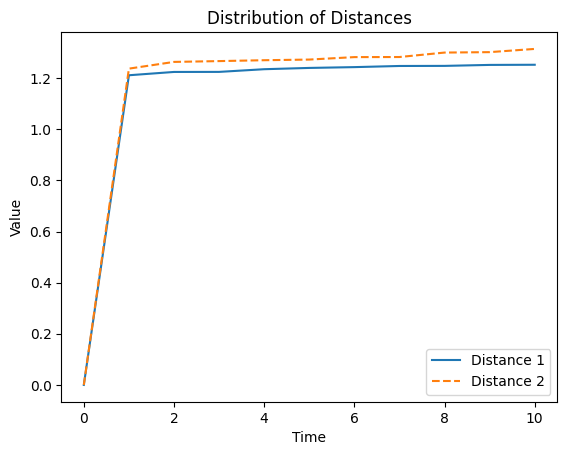

In [ ]:
x = df2['distance_1']
y =  df2['distance_2']
plt.plot(x, '-', label='Distance 1');
plt.plot(y, '--', label='Distance 2');
plt.title('Distribution of Distances')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

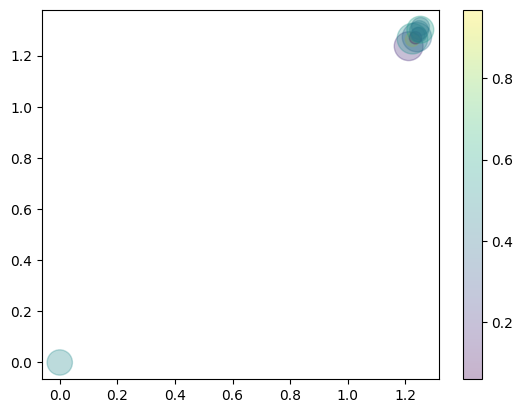

In [ ]:
n = 11
x = df2['distance_1']
y = df2['distance_2']
colors = np.random.random(n)
sizes = 500 * np.random.random(n)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3, cmap='viridis')
plt.colorbar() ;

### Sentiment of the person

In [ ]:
count = 0 # Starting a counter to give our output an index
for index in indices2[0]: # Looping to find the Sentiment of each individual
  text = rsult_df.iloc[index]['text']
  blob = TextBlob(text)
  sentiment_score = blob.sentiment
  person = group_of_p[index]
  count += 1
  all = {"index": count, "Person":person, }
  print(f"{count} sentiment scores are: {sentiment_score}")

1 sentiment scores are: Sentiment(polarity=0.10671296296296297, subjectivity=0.35462962962962963)
2 sentiment scores are: Sentiment(polarity=0.0952020202020202, subjectivity=0.3120979020979021)
3 sentiment scores are: Sentiment(polarity=0.12772288098375054, subjectivity=0.41680939833113745)
4 sentiment scores are: Sentiment(polarity=0.10882352941176471, subjectivity=0.18431372549019606)
5 sentiment scores are: Sentiment(polarity=0.10484848484848484, subjectivity=0.3517171717171718)
6 sentiment scores are: Sentiment(polarity=0.1208712121212121, subjectivity=0.339810606060606)
7 sentiment scores are: Sentiment(polarity=0.028951277480689243, subjectivity=0.21409685086155672)
8 sentiment scores are: Sentiment(polarity=0.16188197767145138, subjectivity=0.38054226475279107)
9 sentiment scores are: Sentiment(polarity=0.12237105568963975, subjectivity=0.3124184321086976)
10 sentiment scores are: Sentiment(polarity=0.13181818181818178, subjectivity=0.33499999999999996)
11 sentiment scores are: 

## Part 3

In [ ]:
person_dropdown = widgets.Dropdown(options=sorted(df['name'])) # Creating an interactive dropdown from our name column

In [ ]:
def person(text):

  '''
This function will take as input the name selected from the person_dropdown variable and will iterate to output the 10 nearest people around the selected person,
display the distance of each other, display the sentiments both polarity and subjectivity and then plot the results in a bar plot
  '''

  print(f"The person is {text}") # We will use this line to display the name of the selcted person
  index = df[df['name'] == text].index[0] # parcing the index for the selected person
  per = tf_idf[index] # Creating the reference from our tf_idf matrix
  distances3, indices3 = kn.kneighbors(
      X=per, ## Fitting the reference into the K- nearest Neighbor model
      n_neighbors=11 # Selecting the 10 nearest people around the selected person
  )
  group_of_p1 = [x for i, x in enumerate(df['name']) if i in indices3[0]] # Retrieving all the names from our KNN model

  sentiments = [] # Creating and empty list to append the polarity and subjectivity of each individual
  for name in group_of_p1: # Looping over all the selected individuals to extract the sentiment values
      person_text = df[df['name'] == name]['text'].values[0]
      blob = TextBlob(person_text)
      sentiments.append((blob.sentiment.polarity, blob.sentiment.subjectivity)) # Appending both polarity and subjectivity individually to our empty list.

  dataframe = {'Names': group_of_p1, 'Person_distance_1': distances3.squeeze(), 'Polarity': [s[0] for s in sentiments], 'Subjectivity': [s[1] for s in sentiments]} # Dict of our values
  final = pd.DataFrame(dataframe) # Creating a data frame with the dictionary containing all the values

  print(final) # This function will output our dataframe

  final.plot(kind='bar') # Creating a bar plot to generate a vizualization of every iteration
  plt.title('Distance to Reference Person')
  plt.xlabel('Person index')
  plt.ylabel('Distance')
  plt.xticks(rotation=45)
  plt.show()

In [ ]:
out = widgets.interactive_output(person, {'text': person_dropdown})

display(person_dropdown, out)

Dropdown(options=(' Renate Lorenz', '%C3%80lex Rigola', '%C3%81g%C3%BAsta Eva Erlendsd%C3%B3ttir', '%C3%81ine …

Output()